Laura A. Dahlberg 2019-09-22

## Building an Automated Diagnosis Model with Transfer Learning
----
In this project we will retrain the 'inception v3' image classifier on the pneumonia dataset using Tensorflow+Keras.

## Workflow
1. Import libraries
1. Project setup:
    1. Create directories
    1. Get data
    1. Helper functions
1. Explore data
1. Preprocessing
1. Load the pre-trained model: inceptionv3
1. Freeze the required layers
1. Create new sequential model with final layers
1. Train the model
1. Save the model/checkpoint
1. Inspect the model
1. May train more times (if needed). Repeat last 4 steps until satisfy with results
1. Summary of result

### Import libraries
---

In [49]:
import sys
import os
import shutil
import argparse
import time
import datetime
from tqdm import tqdm
import inspect
import gc
from pathlib import Path

import random
from collections import Counter
import numpy as np
import pandas as pd
import re

from PIL import Image
import cv2

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.applications.inception_v3 import InceptionV3  #this is the inception model
from keras.constraints import maxnorm
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf

from IPython.display import display
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Project Setup: Create directories

Directory structure
```
├── README.md          <- The top-level README for developers using this project.
├── data
│    ├── input
│    │    ├── train       
│    │    │     ├── normal
│    │    │     └── pneumonia
│    │    │     
│    │    ├── val             
│    │    │    ├── normal
│    │    │    └── pneumonia
│    │    │    
│    │    └── test 
│    │         ├── normal
│    │         └── pneumonia
│    │         
│    │    
│    └──output        
│         ├── figures
│         │    ├── result
│         │    └── sample
│         │
│         ├── models
│         └── logs
│
└── code
```

In [2]:
PROJ_PATH = Path.cwd()

DATA = PROJ_PATH/'data'
DATA.mkdir(exist_ok=True)

## if downloading data from kaggle, rename "chest_xray" directory from kaggle set to "input"
INPUT = DATA/'input'
INPUT.mkdir(exist_ok=True)

OUTPUT = DATA/'output'
OUTPUT.mkdir(exist_ok=True)

FIGURES = OUTPUT/'figures'
FIGURES.mkdir(exist_ok=True)

RESULT = FIGURES/'result'
RESULT.mkdir(exist_ok=True)

SAMPLE = FIGURES/'sample'
SAMPLE.mkdir(exist_ok=True)

MODELS = OUTPUT/'models'
MODELS.mkdir(exist_ok=True)

LOGS = OUTPUT/'logs'
LOGS.mkdir(exist_ok=True)

TRAINING_DIR = INPUT/"train"
VALIDATION_DIR = INPUT/"val"
TESTING_DIR = INPUT/"test"

### Project Setup: Get data
---

In [4]:
## I got the data through the Kaggle API in the command line.
## Then, I renamed the "chest_xray" directory, from kaggle set, to "input"
## To download the whole dataset visit kaggle. See "Resources" 
## section, at the bottom of this notebook, for link. 

## I uploaded 5 image files for each category, so you can run this code.

In [67]:
## checking that the data is there

%ls {INPUT}

test/  train/  val/


### Project Setup: Helper functions
---

In [6]:
# print date and time for given type of representation
def date_time():
    """ 
    Convenience method to track project start times, in various formats 
    """
    return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())

In [7]:
def dir_file_count(directory): 
    """
    this function is used to calculate the `batch_size`. Used in: 
    `validation_datagen.flow_from_directory()` to create variable `validation_generator`, and
    `test_datagen.flow_from_directory()` to create var `test_generator`
    """
    return sum([len(files) for r, d, files in os.walk(directory)])

In [8]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    """
    This is used in functions `show_class_sample_images()`, `count_bar_plot()`,
    and `classes` variable, 
    """
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

In [9]:
## Data visualization
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols
    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], 
                          title_fontsize = 18, label_fontsize = 14, image_file_name="", 
                          save = False, dpi=100, update_image=True):
    plot_params = {}
    plot_params["figsize"] = figsize
    plot_params["title"] = title
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    plot_params["legends"] = legends 
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    plot_params["subplot"] = None
    return plot_params

In [11]:
def select_image_by_category(image_dir, image_count_per_category):
    """
    Convenience function to view/inspect sample images. Used in `show_class_sample_images`
    Paremeter:`image_dir` is either `TRAINING_DIR` or another directory of images like validation or test
    Parameter: `image_count_per_category` the number of sample in each category.
    """
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*15, name_correct(class_name), "-"*15))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")

In [12]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(TRAINING_DIR, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(TRAINING_DIR, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [13]:
# reset tensorflow graph to free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

### Explore data
---

Number of Class:  2
---------------Normal---------------


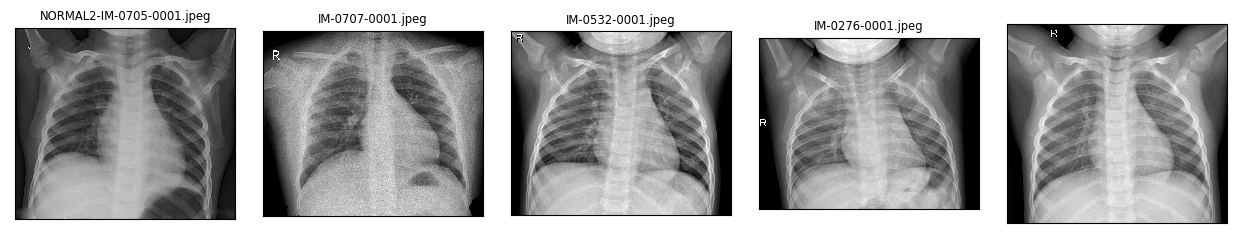


---------------Pneumonia---------------


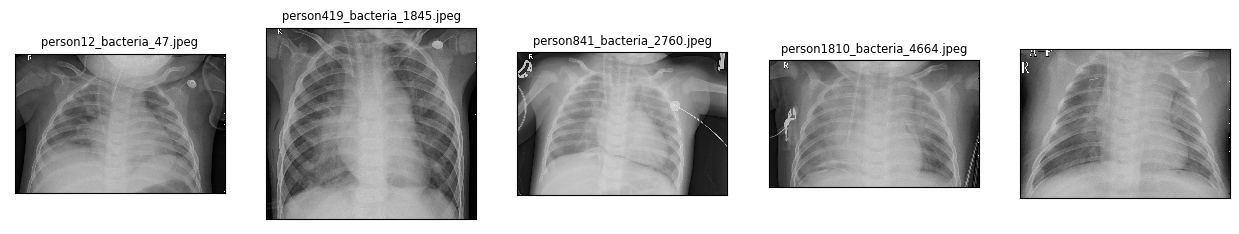

In [14]:
show_class_sample_images(str(TRAINING_DIR), image_count_per_category=5, save=False, dpi=100, update_image=False)

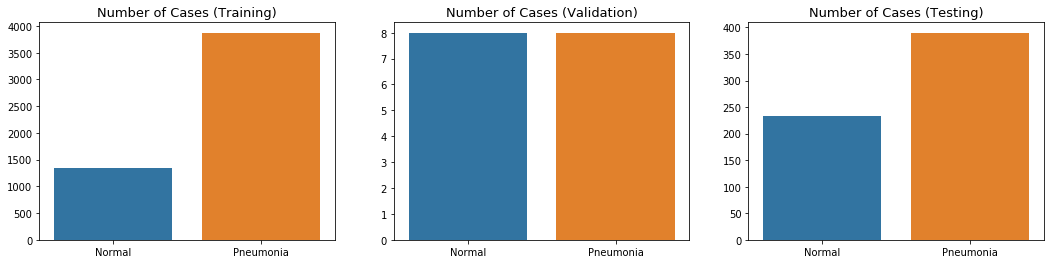

In [15]:
## examining the ration of classes in each dataset
plot_params = get_reset_plot_params()
plot_params['figsize'] = (18,4)
plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10
plot_params['title'] = "Number of Cases"
plot_params['subplot'] = 131
show_train_val_test(str(TRAINING_DIR), str(VALIDATION_DIR), str(TESTING_DIR), plot_params)
classes = [d.name for d in TRAINING_DIR.iterdir() if d.is_dir()]
classes = [name_correct(i) for i in classes]

### Preprocessing
---

#### Image Preprocessing/ Augmentation/ Transformation for Training, Validation, Testing and  Dataset 

To help prevent overfitting and aid the model generalize better, we add a number of random transformations. This way, the model would never see twice the exact same picture, and it will make it resilient to not needing perfect data. 
We will use the following parameters to transform our data:
- `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `horizontal_flip` is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [16]:
## variables for data generators
rescale = 1./255
target_size = (150, 150)
## For this I used a batch size of 163, but  I only uploaded 5 image files for each category,to the repo.
#batch_size = 163
batch_size = 5
class_mode = "categorical"

## uncomment below to see what happens with no data augmentation
#train_datagen = ImageDataGenerator(rescale=rescale)

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=rescale,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


## `flow_from_directory` takes the path to a directory and 
## generates batches of augmented data
train_generator = train_datagen.flow_from_directory(
    str(TRAINING_DIR),
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    str(VALIDATION_DIR),
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(str(VALIDATION_DIR)),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    str(TESTING_DIR),
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count( str(TESTING_DIR)),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


###  Training Files Configuration

In [17]:
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [18]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [19]:
# CREATE SUBDIRS for EACH NOTEBOOK RUN
#model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
model_dir = MODELS/time.strftime('%Y-%m-%d %H-%M-%S')
model_dir.mkdir(exist_ok=True)

log_dir =LOGS/time.strftime('%Y-%m-%d %H-%M-%S')
log_dir.mkdir(exist_ok=True)

# this names the file for the run in hdf5 datastore
model_file = str(model_dir) + "/{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

### Callbacks

Keras callbacks return information from a training algorithm while training is taking place.
You can use callbacks to get a view on internal states and statistics of the model during training.

In [20]:
reset_graph()
reset_callbacks()

W0921 21:51:52.972506 140530371987264 deprecation_wrapper.py:119] From /home/laura/anaconda3/envs/transfer_learning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0921 21:51:52.973410 140530371987264 deprecation_wrapper.py:119] From /home/laura/anaconda3/envs/transfer_learning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0921 21:51:52.987539 140530371987264 deprecation_wrapper.py:119] From /home/laura/anaconda3/envs/transfer_learning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [21]:
## creating save name and passing only the best models
print("Settting Callbacks at ", date_time())

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#---------------------------------------------------------------
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]

print("Set Callbacks at ", date_time())

Settting Callbacks at  Timestamp: 2019-09-21 21:51:56
Set Callbacks at  Timestamp: 2019-09-21 21:52:01


### Load the pre-trained model: inceptionv3
---
Load a model that's already been trained (one of the checkpoints)
```
model = keras.load_model('path/to/model.hdf5')
```

In [26]:
# Load and configure model InceptionV3 for fine-tuning with new class labels

## load the v3 model, create the base pre-trained model, channel last
v3_base = InceptionV3(weights='imagenet', include_top=False)
print('model loaded')

87916544/87910968 [==============================] - 23s 0us/step
model loaded


### Create new sequential model with final layers
---

In [32]:
# add our classifier on top of v3
x = v3_base.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=v3_base.input, outputs=predictions)

### Freeze the required layers
---

In [33]:
# transfer learning
# Freeze the layers except the top layer
for layer in v3_base.layers:
    layer.trainable = False

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, None, None 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 32, None, Non 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 32, None, Non 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 32, None, Non 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

### Train the model
---

In [36]:
print("Starting Trainning Model", date_time())

steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

epochs = 10

## compiling the model
model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Completed Model Trainning", date_time())

W0921 22:15:15.093639 140530371987264 deprecation_wrapper.py:119] From /home/laura/anaconda3/envs/transfer_learning/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0921 22:15:15.166393 140530371987264 deprecation.py:323] From /home/laura/anaconda3/envs/transfer_learning/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Starting Trainning Model Timestamp: 2019-09-21 22:15:15


W0921 22:15:16.696238 140530371987264 deprecation_wrapper.py:119] From /home/laura/anaconda3/envs/transfer_learning/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0921 22:15:16.696837 140530371987264 deprecation_wrapper.py:119] From /home/laura/anaconda3/envs/transfer_learning/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
 - 172s - loss: 0.5617 - acc: 0.7512 - val_loss: 2.6674 - val_acc: 0.5000
Epoch 2/10
 - 151s - loss: 0.4315 - acc: 0.8173 - val_loss: 0.9676 - val_acc: 0.5625
Epoch 3/10
 - 157s - loss: 0.3862 - acc: 0.8319 - val_loss: 1.1183 - val_acc: 0.5625
Epoch 4/10
 - 155s - loss: 0.3722 - acc: 0.8372 - val_loss: 1.9571 - val_acc: 0.5625
Epoch 5/10
 - 150s - loss: 0.3629 - acc: 0.8436 - val_loss: 1.1107 - val_acc: 0.6250
Epoch 6/10
 - 152s - loss: 0.3341 - acc: 0.8556 - val_loss: 1.1777 - val_acc: 0.6875
Epoch 7/10
 - 153s - loss: 0.3340 - acc: 0.8610 - val_loss: 1.4744 - val_acc: 0.6875

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
Completed Model Trainning Timestamp: 2019-09-21 22:34:16


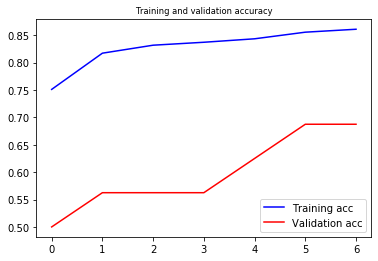

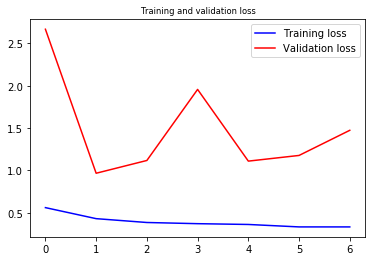

In [37]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training(history)

### Saving the model into a variable
---
It's a good practice to save the latest model, so when you continue the training, you don't start from scratch. You start with the best model so far. 

In [ ]:
# list all of the model dirs and models we just ran
list(MODELS.rglob('*'))

In [47]:
model_file = list(MODELS.rglob('*'))[-1]  # the most recent model file
model_file.name                           # just looking at the name of the file

'06-val_acc-0.69-val_loss-1.18.hdf5'

In [52]:
model = load_model(str(model_file))       # load the most recent model

### Inspect the model
---

In [53]:
## model evaluation
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 34s 34s/step
Loss     : 1.17  
Accuracy : 69.87%


In [54]:
## running model on the test dataset
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
1/1 [==============================] - 27s 27s/step


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 69.20%
Recall        : 93.33%
F1-Score      : 79.48%
------------------------------------------------------------------------------------------





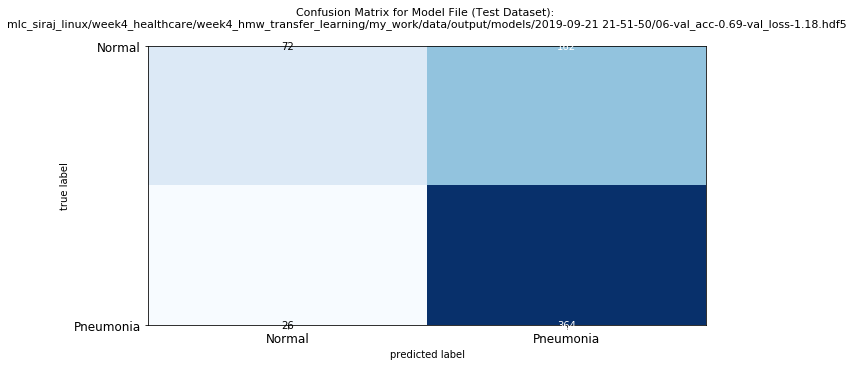




---------------
Report for Model File:  mlc_siraj_linux/week4_healthcare/week4_hmw_transfer_learning/my_work/data/output/models/2019-09-21 21-51-50/06-val_acc-0.69-val_loss-1.18.hdf5
---------------
              precision    recall  f1-score   support

      Normal       0.73      0.31      0.43       234
   Pneumonia       0.69      0.93      0.79       390

    accuracy                           0.70       624
   macro avg       0.71      0.62      0.61       624
weighted avg       0.71      0.70      0.66       624

---------------


In [57]:
image_file_name_CM = FIGURES/"CM"

title = str(model_file).split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+model_title, fontsize=11)
fig.savefig(str(image_file_name_CM), dpi=100)
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*15)
print("Report for Model File: ", model_title)
print("-"*15)
print(cls_report_print)
print("-"*15)

In [58]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 69.87%
-----------------------------------


### Visualizing the predictions
---
We're intersted in looking at examples of when the model was right or wrong. Perhaps we can draw some conclussions. 

In [59]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        #img = cv2.imread(testing_dir+"\\"+ file_names[num], 1) ##<== this line was causing errors
        img = cv2.imread(testing_dir+'/'+file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            
        # these two lines were hasghtaged b/c they werer giving error
        #if plot_params["update_image"] and os.path.exists(image_file_name):
        #    os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

In [61]:
image_file_name_batch = RESULT
image_file_name_sample = SAMPLE

batch_size_t = len(y_true_batch)
class_map = {v: k for k, v in test_generator.class_indices.items()}
dpi=100
ncols = 8
nrows = 4
count = ncols*nrows

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

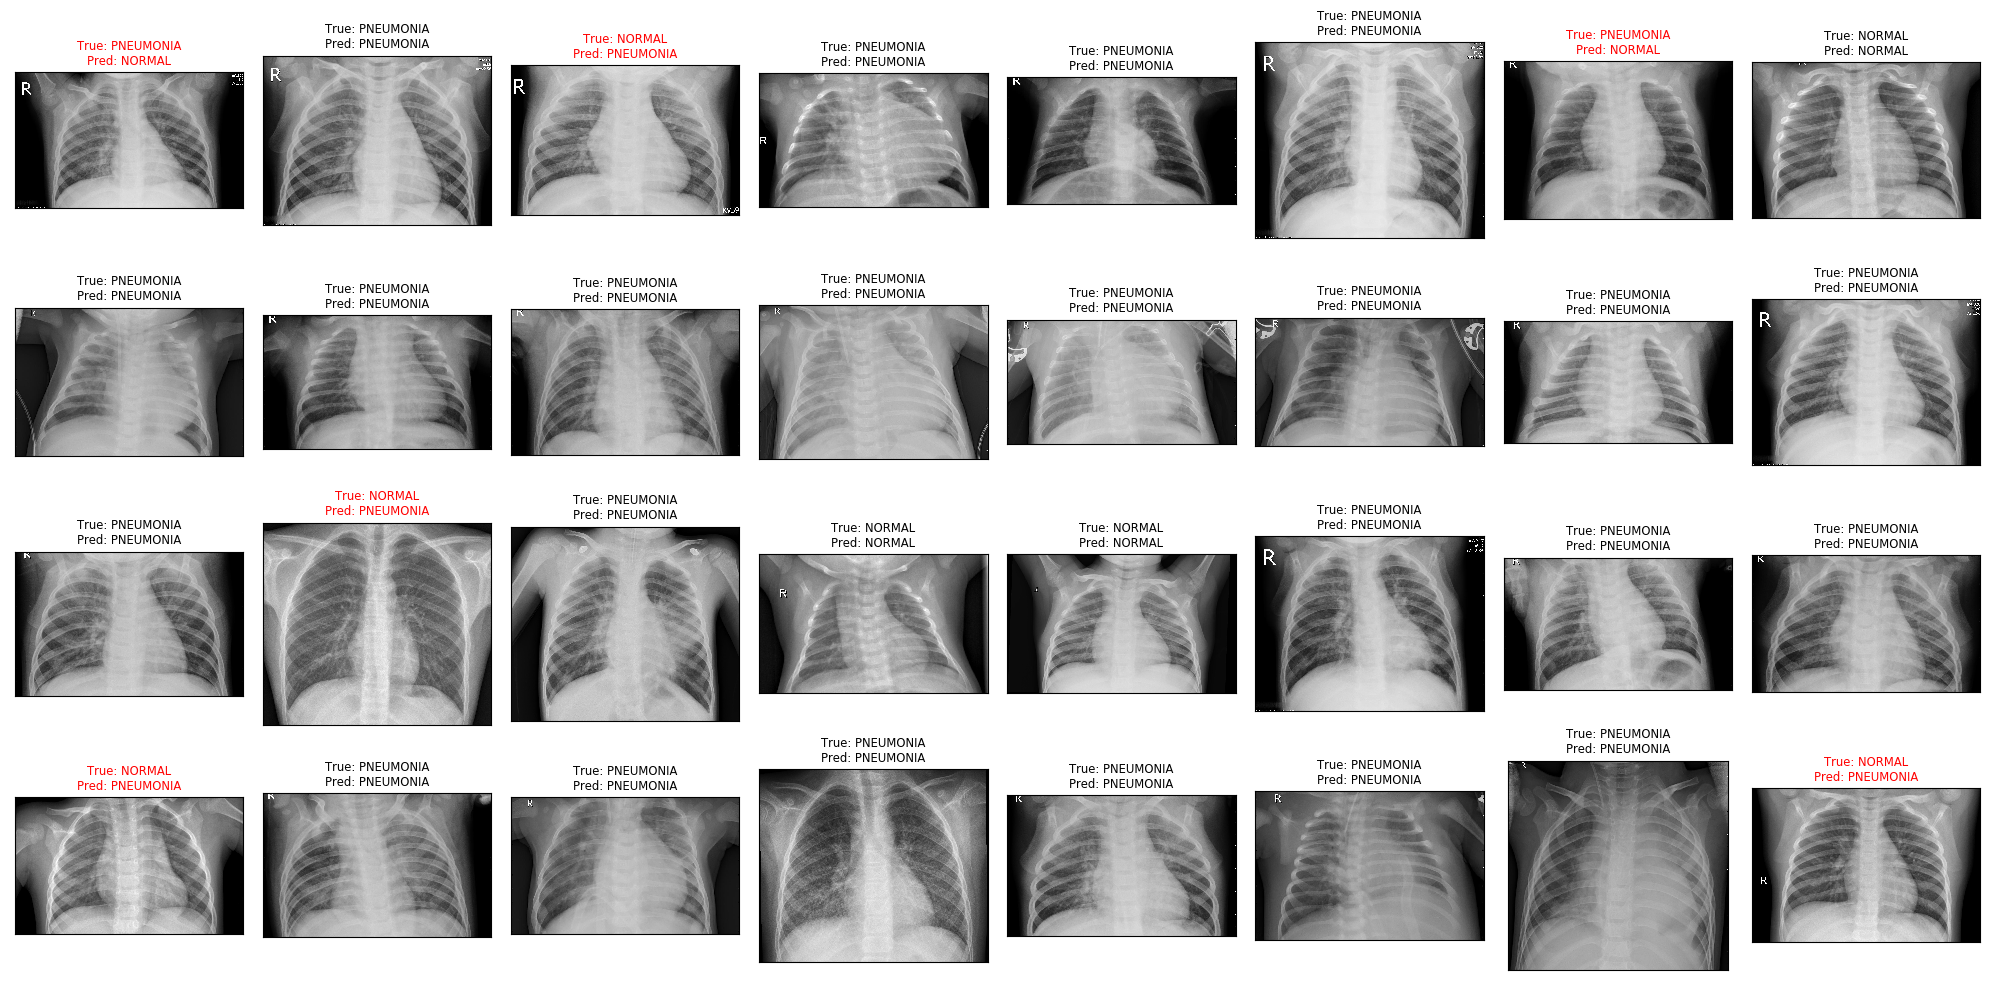

In [63]:
# make preds on examples of the test dataset
show_predictions(y_img_batch, 
                 y_true_batch, 
                 y_pred_batch, 
                 subplot_params, 
                 plot_params, 
                 class_map, 
                 str(TESTING_DIR), 
                 image_file_name_batch, 
                 count=count, 
                 sample=True)

### Summary
---
- I did some data augmentation.
- I dug into what that entail and added some different types of data augmentation
- The model got progressively better. It only got to 7 epochs because the result started to plateau.
- Ways to improve results:
    - Keep training
    - Train more epochs, with parameters as is
    - Continue training, but change parameters 
    - We had a lower droput rate, and we could tray a higher one
    - Training smaller batch sizes

For futher exploration:
- Try this dataset with Pytorch in a different model  like resnet50
- Build a model without data augmentation and one with data augmentation. Then, compare the two of them


### May train more times - if needed. Repeat last 4 steps until satisfied with results
---

### Resources:
---
* [keras blog for image preprocesing](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
* [inception colab example](https://colab.research.google.com/drive/18AN2AUM5sEsTMGUzFUL0FLSULtXF4Ps0#scrollTo=rqhpmAXHz7l1)
* [Examples of fine-tuning inception model](https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes)
* [How to train your model](https://towardsdatascience.com/how-to-train-your-model-dramatically-faster-9ad063f0f718)
* [Tutorial of fine tunning using pre trained models](https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/)
* [Details about keras inception model params](https://keras.io/applications/#inceptionv3)
* Kaggle's Datase Link: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)